# Hyperparameter Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_83397/687462750.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Load Dataset

In [3]:
df = pd.read_csv('../data/processed_data_with_anomaly.csv')

## Definisi Fitur dan Target

In [4]:
features = ['Lag_1_Status', 'Count_Alpa_7D', 'Count_Alpa_30D', 'Streak_Alpa', 'Avg_Arrival_Time_7D', 'DayOfWeek']
le = LabelEncoder()

X = df[features]
# Encode 'Lag_1_Status' in the features
X['Lag_1_Status'] = le.fit_transform(X['Lag_1_Status'].astype(str))

y = le.fit_transform(df['note'].astype(str))

/tmp/ipykernel_83397/3542950029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Lag_1_Status'] = le.fit_transform(X['Lag_1_Status'].astype(str))


## Split Data

In [5]:
# 80% train-test split

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Data Latih: {X_train.shape[0]} baris")
print(f"Data Uji: {X_test.shape[0]} baris")

Data Latih: 89658 baris
Data Uji: 22415 baris


In [6]:
# Define hyperparameter grids for each model
param_grids = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [25, 50, 75, 100],
            'criterion': ['gini', 'entropy'], 
            'min_samples_split': [2, 3, 5], 
            'min_samples_leaf': [15, 20, 30]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [30, 50, 80, 100], 
            'max_depth': [3, 4, 7, 9], 
            'min_samples_split': [2, 5, 8], 
            'max_features' : [2, 3, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='mlogloss', random_state=42),
        'params': {
            'learning_rate': [0.1, 0.15, 0.2], 
            'max_depth': [3, 5, 10], 
            'gamma' : [1, 2, 3],
            'reg_alpha' :[20, 30, 40], 
            'reg_lambda' :[0, 1],
            'colsample_bytree' :[0.5, 0.7, 1],
            'min_child_weight' :[0, 1, 2],
            'n_estimators' :[180], 
            'seed' :[0]
        },
    },
    'Gaussian NB': {
        'model': Pipeline([
            ('scaler', StandardScaler()), 
            ('clf', GaussianNB())
        ]),
        'params': {
            'clf__var_smoothing': [1e-9, 1e-7, 1.0, 1.2, 1.4]
        }
    },
    'SVM': {
        'model': Pipeline([
            ('scaler', StandardScaler()), 
            ('clf', SVC(random_state=42))
        ]),
        'params': {
            'clf__C': [0.5, 1, 2], 
            'clf__kernel': ['linear', 'rbf'], 
            'clf__gamma': ['scale', 'auto']
        }
    }
}

In [7]:
best_params = {}

# TimeSeriesSplit untuk Cross Validation (agar tidak bocor waktu)
tscv = TimeSeriesSplit(n_splits=3)

In [8]:
for name, config in param_grids.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(config['model'], config['params'], cv=tscv, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params[name] = grid.best_estimator_
    print(f"  Best Params: {grid.best_params_}")
    print(f"  Best CV Score: {grid.best_score_:.4f}")

Tuning Decision Tree...


  Best Params: {'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 30, 'min_samples_split': 2}
  Best CV Score: 0.6299
Tuning Random Forest...
  Best Params: {'max_depth': 3, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 80}
  Best CV Score: 0.6790
Tuning XGBoost...
  Best Params: {'colsample_bytree': 0.7, 'gamma': 3, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 180, 'reg_alpha': 40, 'reg_lambda': 1, 'seed': 0}
  Best CV Score: 0.6750
Tuning Gaussian NB...
  Best Params: {'clf__var_smoothing': 1e-09}
  Best CV Score: 0.6863
Tuning SVM...
  Best Params: {'clf__C': 0.5, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
  Best CV Score: 0.6682


## Compare Models


Evaluating Decision Tree...

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.73      0.55      0.63     15074
           1       0.39      0.58      0.47      7341

    accuracy                           0.56     22415
   macro avg       0.56      0.57      0.55     22415
weighted avg       0.62      0.56      0.57     22415


Confusion Matrix for Decision Tree:


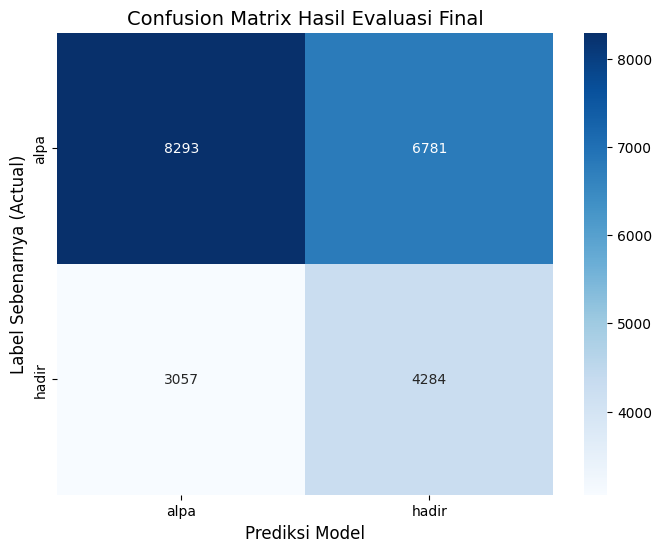


Evaluating Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.56      0.65     15074
           1       0.43      0.67      0.52      7341

    accuracy                           0.60     22415
   macro avg       0.60      0.62      0.59     22415
weighted avg       0.66      0.60      0.61     22415


Confusion Matrix for Random Forest:


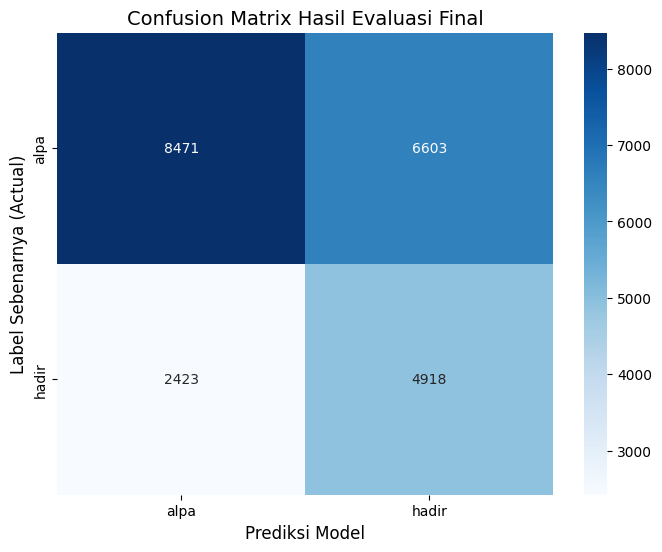


Evaluating XGBoost...

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.73      0.57      0.64     15074
           1       0.39      0.57      0.47      7341

    accuracy                           0.57     22415
   macro avg       0.56      0.57      0.55     22415
weighted avg       0.62      0.57      0.58     22415


Confusion Matrix for XGBoost:


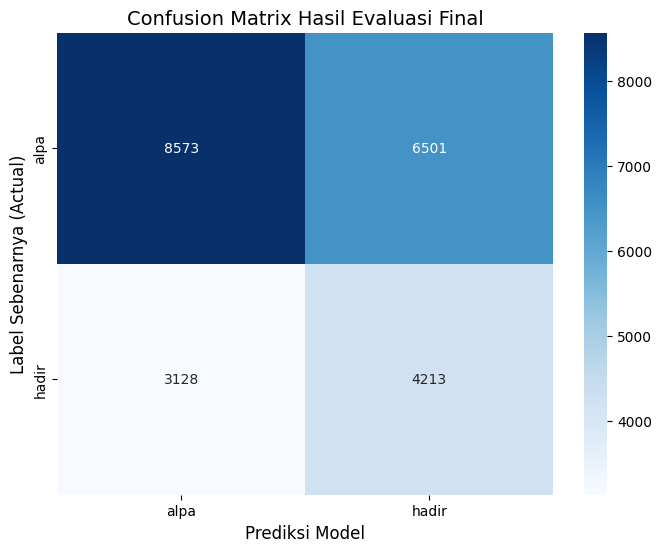


Evaluating Gaussian NB...

Classification Report for Gaussian NB:
              precision    recall  f1-score   support

           0       0.79      0.57      0.66     15074
           1       0.44      0.68      0.53      7341

    accuracy                           0.61     22415
   macro avg       0.61      0.63      0.60     22415
weighted avg       0.67      0.61      0.62     22415


Confusion Matrix for Gaussian NB:


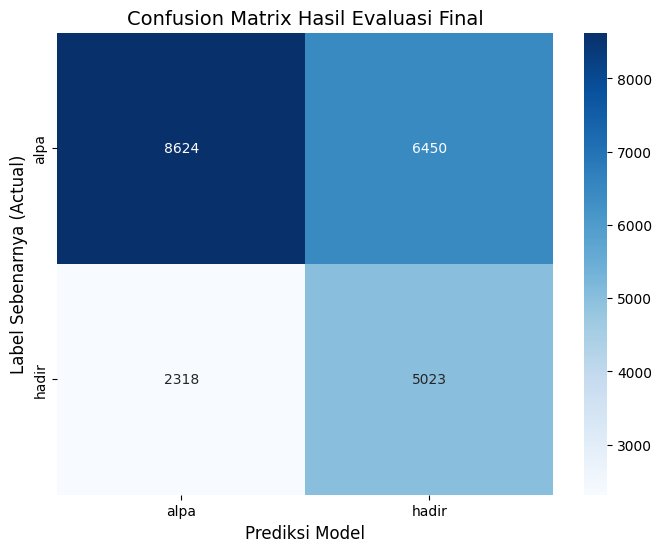


Evaluating SVM...

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.77      0.58      0.66     15074
           1       0.43      0.65      0.51      7341

    accuracy                           0.60     22415
   macro avg       0.60      0.61      0.59     22415
weighted avg       0.66      0.60      0.61     22415


Confusion Matrix for SVM:


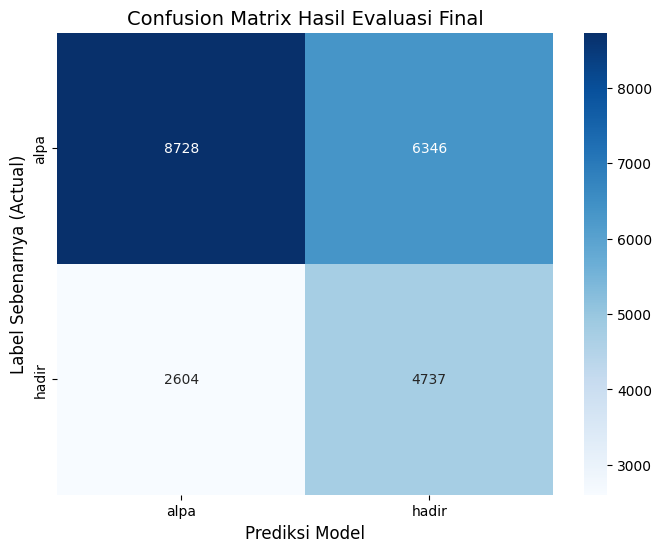

In [9]:
results = []

for name, model in best_params.items():
  print(f"\n{'='*50}")
  print(f"Evaluating {name}...")
  print('='*50)
  
  # Make predictions
  y_pred = model.predict(X_test)
  
  # Calculate metrics
  report = classification_report(y_test, y_pred, output_dict=True)
  
  # Store results
  results.append({
    'Model': name,
    'Accuracy': report['accuracy'],
    'Macro F1': report['macro avg']['f1-score'],
    'Macro Recall': report['macro avg']['recall'],
    'Macro Precision': report['macro avg']['precision']
  })
  
  # Print classification report
  print(f"\nClassification Report for {name}:")
  print(classification_report(y_test, y_pred))
  
  # Print confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  print(f"\nConfusion Matrix for {name}:")

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
              xticklabels=le.classes_, yticklabels=le.classes_)
  plt.xlabel('Prediksi Model', fontsize=12)
  plt.ylabel('Label Sebenarnya (Actual)', fontsize=12)
  plt.title('Confusion Matrix Hasil Evaluasi Final', fontsize=14)
  plt.show()

In [10]:
# Create comparison dataframe
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Macro F1,Macro Recall,Macro Precision
0,Decision Tree,0.561097,0.546594,0.566862,0.558914
1,Random Forest,0.597323,0.586945,0.615948,0.602228
2,XGBoost,0.570422,0.553529,0.571314,0.562948
3,Gaussian NB,0.608833,0.598470,0.628175,0.612983
4,SVM,0.600714,0.587641,0.612145,0.598810


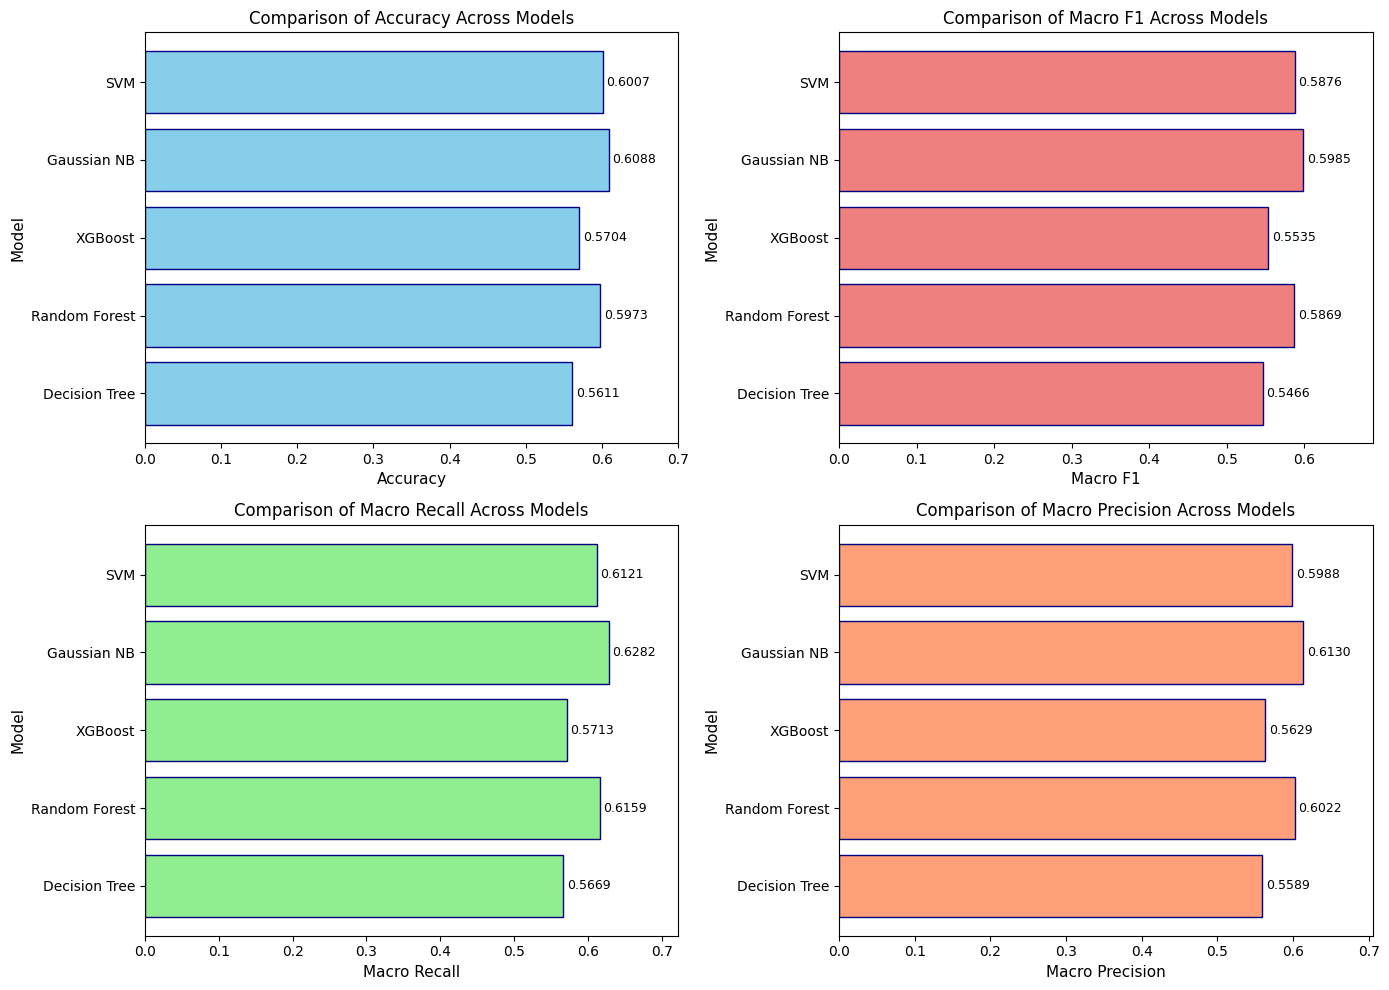

In [12]:
# Create subplots for all metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Macro F1', 'Macro Recall', 'Macro Precision']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon']

for idx, (ax, metric, color) in enumerate(zip(axes.flat, metrics, colors)):
  ax.barh(results_df['Model'], results_df[metric], color=color, edgecolor='navy')
  ax.set_xlabel(metric, fontsize=11)
  ax.set_ylabel('Model', fontsize=11)
  ax.set_title(f'Comparison of {metric} Across Models', fontsize=12)
  ax.set_xlim(0, max(results_df[metric]) * 1.15)
  
  # Add value labels on bars
  for i, (model, score) in enumerate(zip(results_df['Model'], results_df[metric])):
    ax.text(score + 0.005, i, f'{score:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()